In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from sklearn.metrics import confusion_matrix, accuracy_score
from tensorflow.keras import layers

In [2]:
df = pd.read_csv('LYG.csv')
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2016-12-01,2.92,2.93,2.88,2.91,2.427045,5668400
1,2016-12-02,2.92,2.95,2.91,2.94,2.452066,4307500
2,2016-12-05,2.97,3.00,2.96,2.98,2.485427,5806300
3,2016-12-06,3.02,3.07,3.00,3.07,2.560491,6487500
4,2016-12-07,3.12,3.19,3.11,3.19,2.660575,9995800


In [3]:
df.tail()

,Date,Open,High,Low,Close,Adj Close,Volume
1252,2021-11-22,2.61,2.63,2.60,2.60,2.60,4760100
1253,2021-11-23,2.62,2.65,2.62,2.63,2.63,5237100
1254,2021-11-24,2.61,2.62,2.58,2.60,2.60,3756500
1255,2021-11-26,2.41,2.43,2.38,2.43,2.43,7213200
1256,2021-11-29,2.48,2.48,2.43,2.45,2.45,7551100


In [4]:
df.shape

(1257, 7)

In [5]:
close_df = df['Close'] # this is our dependent variable for our stock price 
close_df.shape

(1257,)

In [6]:
close_df.describe()

count    1257.000000
mean        2.812132
std         0.732170
min         1.180000
25%         2.380000
50%         2.960000
75%         3.370000
max         4.190000
Name: Close, dtype: float64

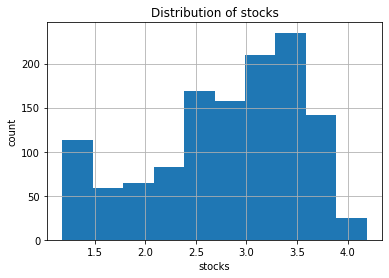

In [7]:
close_df.hist()
plt.xlabel('stocks')
plt.ylabel('count')
plt.title('Distribution of stocks')
plt.show()

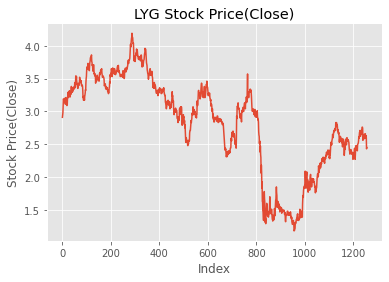

In [8]:
# graph visualisation of stock data
plt.style.use('ggplot')
plt.plot(close_df)
plt.xlabel('Index')
plt.ylabel('Stock Price(Close)')
plt.title('LYG Stock Price(Close)')
plt.show()

In [9]:
# splitting dataset into trian and test
training_size = int(len(close_df) * 0.65) # 65% train size
test_size = len(close_df) - training_size # 35% test size
train_data, test_data = close_df[0:training_size], close_df[training_size:] 
test_data.shape
train_data.shape

(817,)

In [10]:
#converting an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - time_step):
        a = dataset.iloc[i:(i+time_step)]
        dataX.append(a)
        dataY.append(dataset.iloc[i + time_step])
    return np.array(dataX), np.array(dataY)

In [11]:
# splitting dataset into trian and test
time_step = 100
x_train ,y_train = create_dataset(train_data, time_step)
x_test, y_test = create_dataset(test_data, time_step)

In [12]:
from sklearn.preprocessing import MinMaxScaler
scaler_x = MinMaxScaler(feature_range= (0,1)) 
scaler_y = MinMaxScaler(feature_range= (0,1)) 

scaled_x_train = scaler_x.fit_transform(x_train)
scaled_y_train = scaler_y.fit_transform(y_train.reshape(-1, 1))
# transformt the test data

scaled_x_test = scaler_x.transform(x_test)
scaled_y_test = scaler_y.transform(y_test.reshape(-1, 1))

In [13]:
# reshape input into 3D in order to fit into LSTM
scaled_x_train = scaled_x_train.reshape(scaled_x_train.shape + (1,))
scaled_x_test = scaled_x_test.reshape(scaled_x_test.shape + (1,))
print(scaled_x_train.shape, scaled_x_test.shape)

(717, 100, 1) (340, 100, 1)


In [14]:
model = Sequential()
model.add(layers.LSTM(units=64, return_sequences=True, input_shape=(100,1), dropout=0.2))
model.add(layers.LSTM(units=32, return_sequences=True, dropout=0.2))
model.add(layers.LSTM(units=32, return_sequences=True, dropout=0.2))
model.add(layers.LSTM(units=16, dropout=0.2))
model.add(layers.Dense(units=1))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100, 64)           16896     
                                                                 
 lstm_1 (LSTM)               (None, 100, 32)           12416     
                                                                 
 lstm_2 (LSTM)               (None, 100, 32)           8320      
                                                                 
 lstm_3 (LSTM)               (None, 16)                3136      
                                                                 
 dense (Dense)               (None, 1)                 17        
                                                                 
Total params: 40,785
Trainable params: 40,785
Non-trainable params: 0
_________________________________________________________________


In [15]:
model.compile(loss='mean_squared_error', optimizer='adam')

In [16]:
# implementing early stopping and model check point 
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint

# stop training process if the val_loss of the train data is not decreased after 5 epochs
es = EarlyStopping(monitor= "val_loss" , min_delta= 0, patience= 5, verbose=1)

# do not save the weights until and unless the validation loss is not decreased.
mc = ModelCheckpoint(filepath= "saved models/Stacked LSTM for LYG Stocks.h5",
                     monitor="val_loss", verbose=1, save_best_only= True)

In [17]:
hist = model.fit(scaled_x_train, scaled_y_train, validation_data=(scaled_x_test, scaled_y_test), 
epochs=100, batch_size=3, verbose=1, callbacks=[es,mc])

Epoch 1/100
239/239 [==============================] - ETA: 0s - loss: 0.0195
Epoch 00001: val_loss improved from inf to 0.02283, saving model to saved models/Stacked LSTM for LYG Stocks.h5
239/239 [==============================] - 35s 121ms/step - loss: 0.0195 - val_loss: 0.0228
Epoch 2/100
239/239 [==============================] - ETA: 0s - loss: 0.0130
Epoch 00002: val_loss improved from 0.02283 to 0.01790, saving model to saved models/Stacked LSTM for LYG Stocks.h5
239/239 [==============================] - 27s 115ms/step - loss: 0.0130 - val_loss: 0.0179
Epoch 3/100
239/239 [==============================] - ETA: 0s - loss: 0.0109
Epoch 00003: val_loss did not improve from 0.01790
239/239 [==============================] - 27s 114ms/step - loss: 0.0109 - val_loss: 0.0432
Epoch 4/100
239/239 [==============================] - ETA: 0s - loss: 0.0105
Epoch 00004: val_loss did not improve from 0.01790
239/239 [==============================] - 27s 115ms/step - loss: 0.0105 - val_los

In [18]:
# list all data in history
print(hist.history.keys())  #loss and accuracy belongs to input

dict_keys(['loss', 'val_loss'])


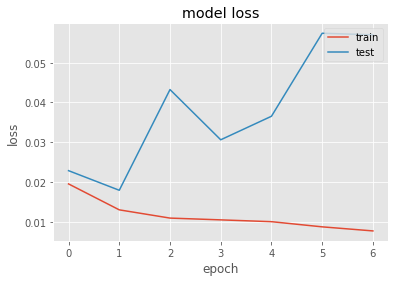

In [19]:
# summarize history for loss
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [20]:
from tensorflow.keras.models import load_model
Model = load_model('saved models/Stacked LSTM for LYG Stocks.h5')

In [21]:
## evaluation on train data
Model.evaluate(scaled_x_train, scaled_y_train, batch_size=1)

717/717 [==============================] - 17s 21ms/step - loss: 0.0082


0.008183701895177364

In [22]:
## evaluation on test data
Model.evaluate(scaled_x_test, scaled_y_test, batch_size=1)

340/340 [==============================] - 7s 21ms/step - loss: 0.0179


0.01789863593876362

In [23]:
train_pred = Model.predict(scaled_x_train)
test_pred = Model.predict(scaled_x_test)

In [24]:
import math
from sklearn.metrics import mean_squared_error
## rmse on test data
math.sqrt(mean_squared_error(scaled_y_test, test_pred))

0.13378575604476375

In [25]:
# Transform Prediction data back into original form
inv_train_pred = scaler_y.inverse_transform(train_pred)
inv_test_pred = scaler_y.inverse_transform(test_pred)

In [26]:
# calculate RMSE Performance metrics(Root Mean squared Error) for Train data
math.sqrt(mean_squared_error(y_train, inv_train_pred))

0.17007195432849784

In [27]:
# RMSE for test data
math.sqrt(mean_squared_error(y_test, inv_test_pred))

0.25151721452339104

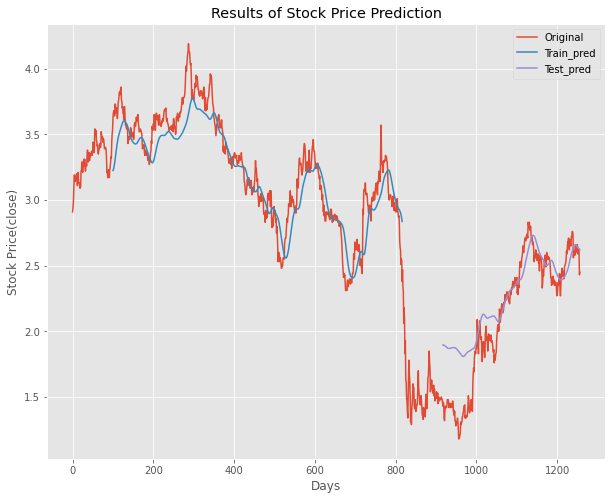

In [28]:
### Plotting 
plt.figure(figsize=(10, 8))

# shift train predictions for plotting(orange)
look_back=100
trainPredictPlot = np.empty_like(close_df)
trainPredictPlot[:] = np.nan
trainPredictPlot[look_back:len(inv_train_pred)+look_back] = inv_train_pred.reshape(inv_train_pred.shape[0])

# shift test predictions for plotting(green)
testPredictPlot = np.empty_like(close_df)
testPredictPlot[:] = np.nan
testPredictPlot[len(inv_train_pred)+(look_back*2):len(close_df)] = inv_test_pred.reshape(inv_test_pred.shape[0])

# plot baseline and predictions (blue)
plt.plot(close_df, label='Original')
plt.plot(trainPredictPlot, label='Train_pred')
plt.plot(testPredictPlot, label='Test_pred')

plt.title('Results of Stock Price Prediction')
plt.xlabel('Days')
plt.ylabel('Stock Price(close)')
plt.legend(loc='best')
plt.show()

In [29]:
x_input = y_test[240:].reshape(1,-1)
x_input.shape

(1, 100)

In [30]:
# scale the input data
sc_x_input = scaler_x.transform(x_input)

In [31]:
temp_input = sc_x_input[0].tolist()

In [32]:
n_steps = len(temp_input)
for i in range(30):
    input_ = temp_input[i:]
    input_ = np.array(input_).reshape(1, n_steps, 1)
    output = Model.predict(input_)[0][0]
    temp_input.append(output) 

In [33]:
len(temp_input)

130

In [34]:
# collect numbers for 100 and 30 days
day_new = np.arange(1,101)
day_pred = np.arange(101,131)

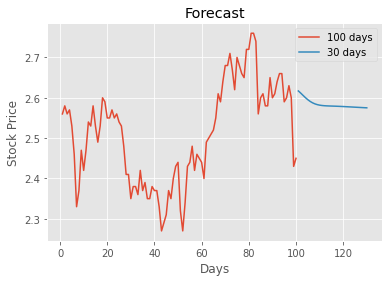

In [35]:
# Partial Plot in which Blue plot is forecast on 30 days
plt.plot(day_new, scaler_y.inverse_transform(np.array(temp_input[:100]).reshape(-1,1)), label='100 days')
plt.plot(day_pred, scaler_y.inverse_transform(np.array(temp_input[100:]).reshape(-1,1)), label='30 days')
plt.xlabel('Days')
plt.ylabel('Stock Price')
plt.title('Forecast')
plt.legend(loc='best')
plt.show()

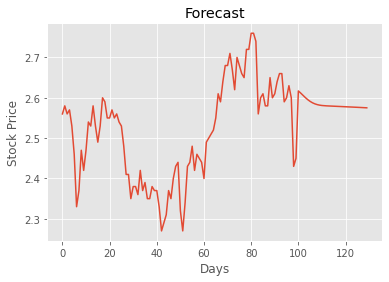

In [36]:
# Plotting the partial Forecast
plt.plot(scaler_y.inverse_transform(np.array(temp_input).reshape(-1,1)))
plt.xlabel('Days')
plt.ylabel('Stock Price')
plt.title('Forecast')
plt.show()

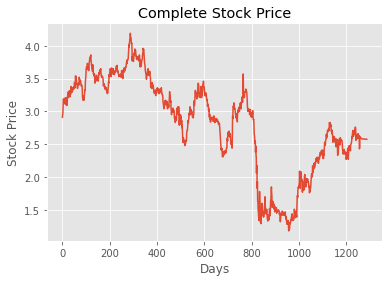

In [37]:
# plotting the complete Graph along with 30 days Forecast
stock_previous = close_df.to_numpy()
stock_30 = scaler_y.inverse_transform(np.array(temp_input[100:]).reshape(1, -1))[0]
Total_stock = np.concatenate([stock_previous, stock_30])
plt.plot(Total_stock)
plt.xlabel('Days')
plt.ylabel('Stock Price')
plt.title('Complete Stock Price')
plt.show()